<a href="https://colab.research.google.com/github/chuancao26/PFC/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data


/tmp/ipython-input-1666039285.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2014-01-01", end="2025-12-01")
[*********************100%***********************]  1 of 1 completed


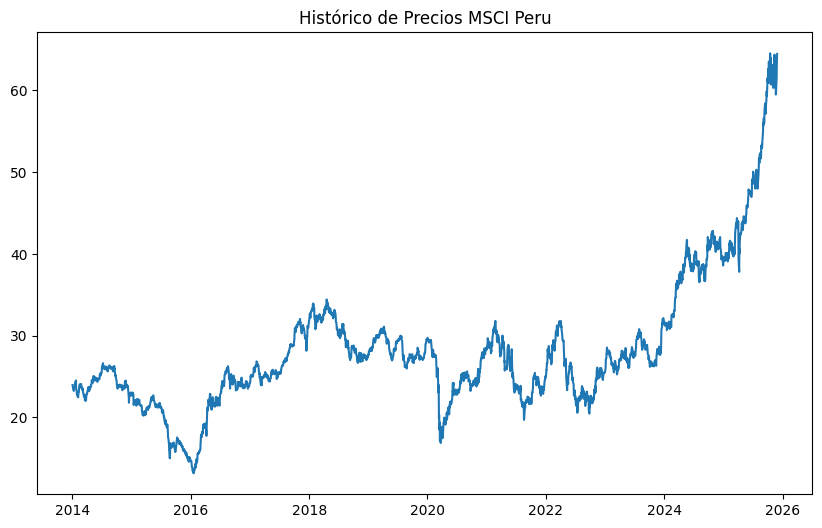

In [50]:
ticker = "EPU"
data = yf.download(ticker, start="2014-01-01", end="2025-12-01")
df = data.Close
df.columns = ["Close"]
plt.figure(figsize=(10,6))
plt.plot(df['Close'], label='MSCI Peru (EPU)')
plt.title('Histórico de Precios MSCI Peru')
plt.show()

## Escalamiento de los datos

In [52]:
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Función para crear ventanas de tiempo (Sliding Window)
# X: Los últimos 60 días
# y: El precio del día siguiente
def create_dataset(dataset, time_step=60):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape para LSTM [samples, time steps, features]
# Features es 1 porque solo usamos el precio de cierre por ahora
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir en Train y Test (No usar train_test_split aleatorio, debe ser secuencial)
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# modelo LSTM

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()

# Capa 1: LSTM
# return_sequences=True porque vamos a apilar otra LSTM
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(Dropout(0.2)) # Para evitar sobreajuste (overfitting)

# Capa 2: LSTM
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Capa de Salida (Predicción del precio)
model.add(Dense(1))

# Compilación
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenamiento (Esto puede tardar unos minutos)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0164 - val_loss: 0.0034
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 8.6877e-04 - val_loss: 0.0031
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 8.0528e-04 - val_loss: 0.0023
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 7.9204e-04 - val_loss: 8.2392e-04
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 7.9253e-04 - val_loss: 6.7987e-04
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 5.8879e-04 - val_loss: 0.0017
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 6.1324e-04 - val_loss: 0.0011
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 5.6446e-04 - val_loss: 0.0010
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 5.0819e-04 - val_loss: 0.0017
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 4.7779e-04 - val_loss: 0.0025
Epoch 12/20
74/74 ━━━━━━━━━━━━

In [54]:
# Predecir
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir la escala (volver a precios reales)
train_predict = scaler.inverse_transform(train_predict)
y_train_real = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_real = scaler.inverse_transform([y_test])

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [55]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Entrenar ARIMA sobre los datos de TRAIN originales (no escalados)
# Order=(5,1,0) es un ejemplo, deberías buscar el óptimo (auto_arima)
# Nota: ARIMA es lento en datasets grandes, quizás debas usar una ventana rodante.
history_arima = [x for x in df['Close'][:train_size]]
predictions_arima = []

# Loop simple de validación (Walk-forward validation) - Simplificado
# NOTA: Esto es solo ilustrativo, para el paper usa pmdarima para optimizar
model_arima = ARIMA(history_arima, order=(5,1,0))
model_fit = model_arima.fit()
output = model_fit.forecast(steps=len(X_test)) # Predicción lineal simple
predictions_arima = output

In [56]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse_lstm = math.sqrt(mean_squared_error(y_test_real[0], test_predict[:,0]))
mape_lstm = mean_absolute_percentage_error(y_test_real[0], test_predict[:,0])

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM MAPE: {mape_lstm}")

# Luego haces lo mismo para ARIMA y comparas.

LSTM RMSE: 2.073064638137611
LSTM MAPE: 0.03626109853900646


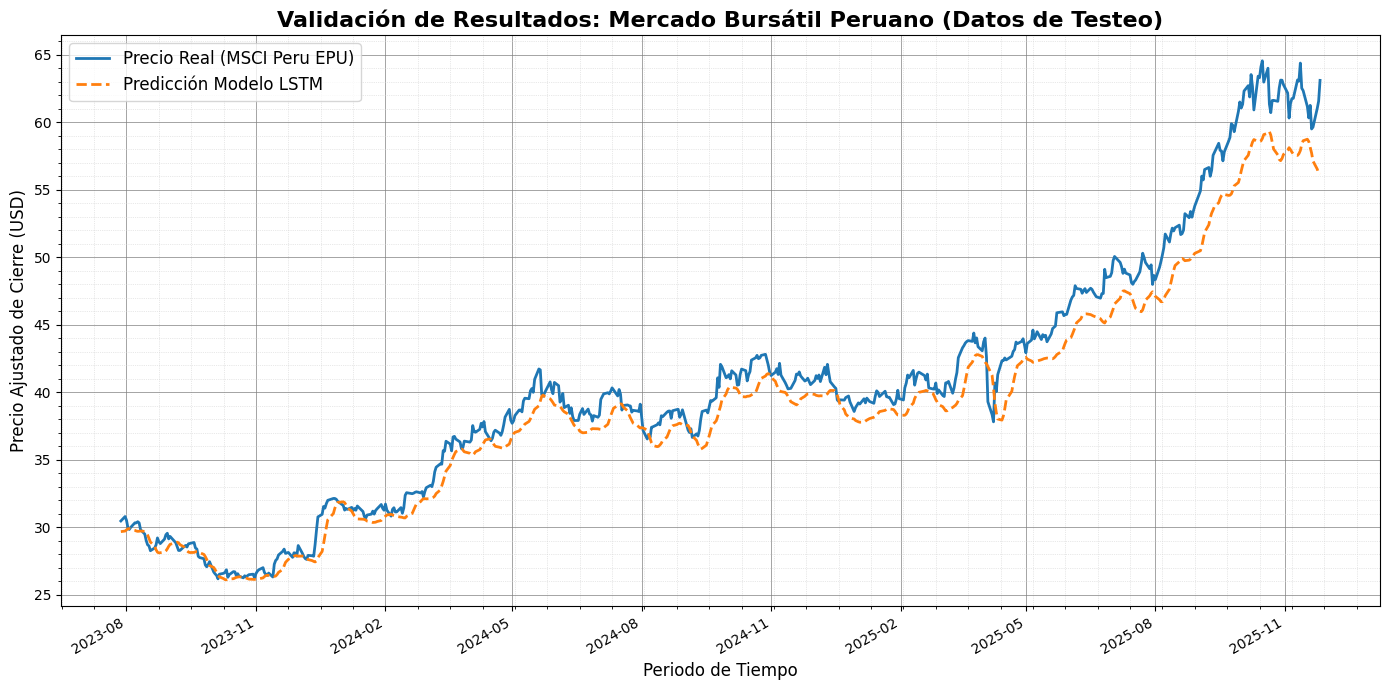

In [57]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- PREPARACIÓN DE DATOS PARA GRAFICAR ---

# Necesitamos asegurarnos de que los datos sean arreglos de una sola dimensión (planos)
# Basado en el código anterior:
# y_test_real tiene forma (1, N) -> usamos [0] para obtener los N elementos.
real_prices = y_test_real[0]
# test_predict tiene forma (N, 1) -> usamos [:,0] para obtener los N elementos.
predicted_prices = test_predict[:,0]


# --- OPCIONAL: RECUPERAR LAS FECHAS REALES ---
# Esto hace que la gráfica se vea mucho más profesional para la tesis.
# Si esto te da error, puedes comentar estas líneas y la gráfica usará índices numéricos.
# Calculamos dónde empieza la data de testeo en el dataframe original
# (train_size + el tamaño de la ventana que usamos para predecir el primer dato de test)
start_test_index = train_size + time_step
# Extraemos las fechas correspondientes del índice del dataframe original
test_dates = df.index[start_test_index : start_test_index + len(real_prices)]


# --- CONFIGURACIÓN DE LA GRÁFICA ---

plt.figure(figsize=(14, 7)) # Hacemos la figura grande y ancha

# 1. Graficar los Precios Reales (Ground Truth)
# Usamos un color sólido y estándar (azul marino)
# Si usas fechas: plt.plot(test_dates, real_prices, ...)
# Si NO usas fechas: plt.plot(real_prices, ...)
plt.plot(test_dates, real_prices, color='#1f77b4', linewidth=2, label='Precio Real (MSCI Peru EPU)')

# 2. Graficar las Predicciones del LSTM
# Usamos un color de contraste (rojo/naranja) y a veces una línea punteada ayuda
# Si usas fechas: plt.plot(test_dates, predicted_prices, ...)
# Si NO usas fechas: plt.plot(predicted_prices, ...)
plt.plot(test_dates, predicted_prices, color='#ff7f0e', linewidth=2, linestyle='--', label='Predicción Modelo LSTM')


# --- ESTÉTICA Y ETIQUETAS (Crucial para el Paper) ---

plt.title('Validación de Resultados: Mercado Bursátil Peruano (Datos de Testeo)', fontsize=16, fontweight='bold')
plt.ylabel('Precio Ajustado de Cierre (USD)', fontsize=12)
plt.xlabel('Periodo de Tiempo', fontsize=12)

# Leyenda: Indica qué es cada línea
plt.legend(loc='best', fontsize=12)

# Grid: Ayuda a leer los valores
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')

# Formato de fechas en el eje X (Solo si usaste test_dates)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Muestra fecha cada 3 meses
plt.gcf().autofmt_xdate() # Rota las fechas para que no se superpongan

plt.tight_layout() # Ajusta los márgenes para que no se corte nada
plt.show()

In [58]:
X_train

array([[[0.21007531],
        [0.20703957],
        [0.20331378],
        ...,
        [0.17309367],
        [0.17792333],
        [0.18592676]],

       [[0.20703957],
        [0.20331378],
        [0.20538371],
        ...,
        [0.17792333],
        [0.18592676],
        [0.18937669]],

       [[0.20331378],
        [0.20538371],
        [0.19889803],
        ...,
        [0.18592676],
        [0.18937669],
        [0.18813471]],

       ...,

       [[0.27611305],
        [0.28026467],
        [0.27939979],
        ...,
        [0.32439678],
        [0.32475104],
        [0.31961493]],

       [[0.28026467],
        [0.27939979],
        [0.27680495],
        ...,
        [0.32475104],
        [0.31961493],
        [0.32988705]],

       [[0.27939979],
        [0.27680495],
        [0.27178844],
        ...,
        [0.31961493],
        [0.32988705],
        [0.33378341]]])